Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Running experiment with ViT-Small (P8-E256-L4-H2)
Number of parameters: 2,188,644
Estimated FLOPs per forward pass: 2,925,156
Epoch 1/30, Train Loss: 4.2010, Train Acc: 6.15%, Test Loss: 4.1312, Test Acc: 6.55%, Time: 9.11s
Epoch 2/30, Train Loss: 3.9875, Train Acc: 8.16%, Test Loss: 4.0016, Test Acc: 8.37%, Time: 8.69s
Epoch 3/30, Train Loss: 3.9071, Train Acc: 9.33%, Test Loss: 3.8513, Test Acc: 10.28%, Time: 8.62s
Epoch 4/30, Train Loss: 3.8515, Train Acc: 10.24%, Test Loss: 3.8787, Test Acc: 9.97%, Time: 8.57s
Epoch 5/30, Train Loss: 3.9194, Train Acc: 9.33%, Test Loss: 3.9233, Test Acc: 9.10%, Time: 8.61s
Epoch 6/30, Train Loss: 3.8935, Train Acc: 9.49%, Test Loss: 3.9976, Test Acc: 8.14%, Time: 8.56s
Epoch 7/30, Train Loss: 3.8618, Train Acc: 10.00%, Test Loss: 3.8007, Test Acc: 11.37%, Time: 8.65s
Epoch 8/30, Train Loss: 3.8628, Train Acc: 10.14%, Test Loss: 3.9030, Test Acc: 9.69%, Ti

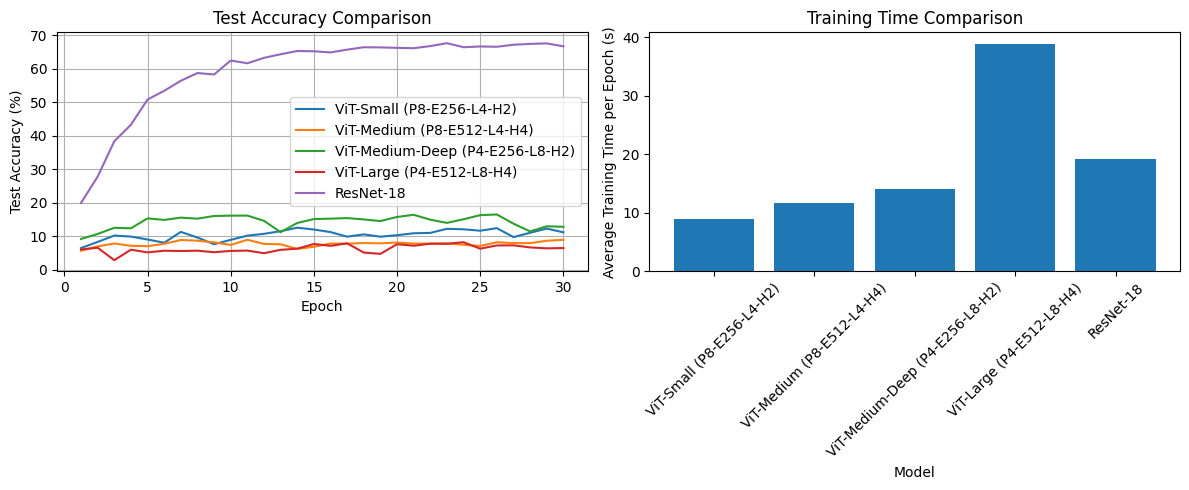

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import time
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the Patch Embedding layer
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=32, patch_size=8, in_channels=3, embed_dim=512):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        
        # Linear projection
        self.proj = nn.Conv2d(
            in_channels, embed_dim, 
            kernel_size=patch_size, stride=patch_size
        )
        
    def forward(self, x):
        # x: [B, C, H, W]
        x = self.proj(x)  # [B, embed_dim, H/patch_size, W/patch_size]
        x = x.flatten(2)  # [B, embed_dim, n_patches]
        x = x.transpose(1, 2)  # [B, n_patches, embed_dim]
        return x

# Define the Multi-Head Self-Attention module
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        
    def forward(self, x):
        # x: [B, n_patches + 1, embed_dim]
        B, N, C = x.shape
        
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)  # Each has shape [B, num_heads, N, head_dim]
        
        # Scaled dot-product attention
        attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)  # [B, num_heads, N, N]
        attn = attn.softmax(dim=-1)
        
        # Apply attention weights to values
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)  # [B, N, C]
        x = self.proj(x)
        return x

# Define the MLP block
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

# Define a Transformer Encoder Block
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(
            in_features=embed_dim,
            hidden_features=int(embed_dim * mlp_ratio),
            out_features=embed_dim
        )
        
    def forward(self, x):
        # Pre-norm architecture
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

# Define the Vision Transformer (ViT) model
class VisionTransformer(nn.Module):
    def __init__(
        self, 
        img_size=32, 
        patch_size=8, 
        in_channels=3, 
        num_classes=100,
        embed_dim=512, 
        depth=6, 
        num_heads=8, 
        mlp_ratio=4.0
    ):
        super().__init__()
        self.patch_embed = PatchEmbedding(
            img_size=img_size,
            patch_size=patch_size,
            in_channels=in_channels,
            embed_dim=embed_dim
        )
        
        num_patches = self.patch_embed.n_patches
        
        # Class token and position embeddings
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        
        # Transformer encoder blocks
        self.blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_ratio)
            for _ in range(depth)
        ])
        
        # Classification head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        
        # Initialize parameters
        self._init_weights()
        
    def _init_weights(self):
        # Initialize patch embedding, class token, and position embedding
        nn.init.normal_(self.cls_token, std=0.02)
        nn.init.normal_(self.pos_embed, std=0.02)
        
        # Initialize transformer blocks
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
                
    def forward(self, x):
        # x: [B, C, H, W]
        batch_size = x.shape[0]
        
        # Patch embedding
        x = self.patch_embed(x)  # [B, n_patches, embed_dim]
        
        # Add class token
        cls_token = self.cls_token.expand(batch_size, -1, -1)  # [B, 1, embed_dim]
        x = torch.cat((cls_token, x), dim=1)  # [B, n_patches + 1, embed_dim]
        
        # Add position embeddings
        x = x + self.pos_embed  # [B, n_patches + 1, embed_dim]
        
        # Apply Transformer blocks
        for block in self.blocks:
            x = block(x)
        
        # Classification head
        x = self.norm(x)
        x = x[:, 0]  # Only use the class token for classification
        x = self.head(x)
        
        return x

# Helper function to count parameters and calculate FLOPs
def count_params_and_flops(model, input_size=(1, 3, 32, 32)):
    """Count parameters and estimate FLOPs using torchinfo."""
    model_summary = summary(model, input_size=input_size, verbose=0)
    params = model_summary.total_params
    flops = model_summary.total_mult_adds
    return params, flops
    
# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    train_loss = running_loss / len(train_loader)
    train_acc = 100.0 * correct / total
    epoch_time = time.time() - start_time
    
    return train_loss, train_acc, epoch_time

# Evaluation function
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    test_loss = running_loss / len(test_loader)
    test_acc = 100.0 * correct / total
    
    return test_loss, test_acc

# Function to train and evaluate a model configuration
def run_experiment(model, model_name, train_loader, test_loader, num_epochs=10):
    print(f"Running experiment with {model_name}")
    
    # Calculate parameters and FLOPs
    params, flops = count_params_and_flops(model)
    print(f"Number of parameters: {params:,}")
    print(f"Estimated FLOPs per forward pass: {flops:,}")
    
    # Set up training
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    model.to(device)
    results = {
        "model_name": model_name,
        "params": params,
        "flops": flops,
        "train_time_per_epoch": [],
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    for epoch in range(num_epochs):
        # Train
        train_loss, train_acc, epoch_time = train(model, train_loader, criterion, optimizer, device)
        
        # Evaluate
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)
        
        # Record results
        results["train_time_per_epoch"].append(epoch_time)
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%, Time: {epoch_time:.2f}s")
    
    # Calculate average metrics
    results["avg_train_time"] = np.mean(results["train_time_per_epoch"])
    results["final_test_acc"] = results["test_acc"][-1]
    
    return results

# Main function to run the experiments
def main():
    # Data preprocessing
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ])
    
    # Load CIFAR-100 dataset
    trainset = torchvision.datasets.CIFAR100(
        root='./data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=64, shuffle=True, num_workers=2)
    
    testset = torchvision.datasets.CIFAR100(
        root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=64, shuffle=False, num_workers=2)
    
    # Define different ViT configurations
    vit_configs = [
        # Config 1: Small ViT (Patch=8x8, Embed=256, Layers=4, Heads=2, MLP=512)
        {
            "name": "ViT-Small (P8-E256-L4-H2)",
            "patch_size": 8,
            "embed_dim": 256,
            "depth": 4,
            "num_heads": 2,
            "mlp_ratio": 2.0
        },
        # Config 2: Medium ViT (Patch=8x8, Embed=512, Layers=4, Heads=4, MLP=2048)
        {
            "name": "ViT-Medium (P8-E512-L4-H4)",
            "patch_size": 8,
            "embed_dim": 512,
            "depth": 4,
            "num_heads": 4,
            "mlp_ratio": 4.0
        },
        # Config 3: Medium-Deep ViT (Patch=4x4, Embed=256, Layers=8, Heads=2, MLP=512)
        {
            "name": "ViT-Medium-Deep (P4-E256-L8-H2)",
            "patch_size": 4,
            "embed_dim": 256,
            "depth": 8,
            "num_heads": 2,
            "mlp_ratio": 2.0
        },
        # Config 4: Large ViT (Patch=4x4, Embed=512, Layers=8, Heads=4, MLP=2048)
        {
            "name": "ViT-Large (P4-E512-L8-H4)",
            "patch_size": 4,
            "embed_dim": 512,
            "depth": 8,
            "num_heads": 4,
            "mlp_ratio": 4.0
        }
    ]
    
    # Create models and run experiments
    num_epochs = 30  
    all_results = []
    
    # Run ViT experiments
    for config in vit_configs:
        model = VisionTransformer(
            img_size=32,
            patch_size=config["patch_size"],
            in_channels=3,
            num_classes=100,
            embed_dim=config["embed_dim"],
            depth=config["depth"],
            num_heads=config["num_heads"],
            mlp_ratio=config["mlp_ratio"]
        )
        
        results = run_experiment(
            model=model,
            model_name=config["name"],
            train_loader=trainloader,
            test_loader=testloader,
            num_epochs=num_epochs
        )
        
        all_results.append(results)
    
    # Run ResNet-18 experiment
    resnet18 = torchvision.models.resnet18(weights=None)
    # Modify the first layer for CIFAR-100 (smaller images)
    resnet18.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    resnet18.maxpool = nn.Identity()  # Remove maxpool layer
    # Modify the final FC layer for 100 classes
    resnet18.fc = nn.Linear(512, 100)
    
    resnet_results = run_experiment(
        model=resnet18,
        model_name="ResNet-18",
        train_loader=trainloader,
        test_loader=testloader,
        num_epochs=num_epochs
    )
    
    all_results.append(resnet_results)
    
    # Print results summary table
    print("\nResults Summary:")
    print("-" * 100)
    print(f"{'Model':<25} | {'Params':<12} | {'FLOPs':<15} | {'Avg Train Time':<15} | {'Final Test Acc':<15}")
    print("-" * 100)
    
    for result in all_results:
        print(f"{result['model_name']:<25} | {result['params']:,} | {result['flops']:,} | {result['avg_train_time']:.2f}s | {result['final_test_acc']:.2f}%")
    
    # Visualize accuracy comparison
    plt.figure(figsize=(12, 5))
    
    # Plot test accuracy
    plt.subplot(1, 2, 1)
    for result in all_results:
        plt.plot(range(1, num_epochs+1), result['test_acc'], label=result['model_name'])
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy (%)')
    plt.title('Test Accuracy Comparison')
    plt.legend()
    plt.grid(True)
    
    # Plot training time
    plt.subplot(1, 2, 2)
    model_names = [result['model_name'] for result in all_results]
    avg_times = [result['avg_train_time'] for result in all_results]
    plt.bar(model_names, avg_times)
    plt.xlabel('Model')
    plt.ylabel('Average Training Time per Epoch (s)')
    plt.title('Training Time Comparison')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    plt.savefig('results_comparison.png')
    plt.show()

if __name__ == "__main__":
    main()

C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Loading Swin-Tiny pretrained model...


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([100, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running experiment with Swin-Tiny (Fine-tuned)
Number of trainable parameters: 76,900
Epoch 1/3, Train Loss: 4.2101, Train Acc: 19.84%, Test Loss: 3.8165, Test Acc: 38.38%, Time: 81.35s
Epoch 2/3, Train Loss: 3.4352, Train Acc: 48.25%, Test Loss: 3.1475, Test Acc: 53.03%, Time: 81.16s
Epoch 3/3, Train Loss: 2.8460, Train Acc: 55.70%, Test Loss: 2.6471, Test Acc: 57.45%, Time: 80.91s
Loading Swin-Small pretrained model...


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\andre\.cache\huggingface\hub\models--microsoft--swin-small-patch4-window7-224. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some wei

Running experiment with Swin-Small (Fine-tuned)
Number of trainable parameters: 76,900
Epoch 1/3, Train Loss: 4.1743, Train Acc: 23.10%, Test Loss: 3.7459, Test Acc: 43.26%, Time: 119.74s
Epoch 2/3, Train Loss: 3.3430, Train Acc: 52.50%, Test Loss: 3.0313, Test Acc: 56.18%, Time: 119.25s
Epoch 3/3, Train Loss: 2.7109, Train Acc: 59.08%, Test Loss: 2.5002, Test Acc: 60.30%, Time: 119.20s
Creating Swin-Tiny model from scratch...
Running experiment with Swin-Tiny (From Scratch)
Number of trainable parameters: 27,596,254
Epoch 1/3, Train Loss: 4.0350, Train Acc: 8.38%, Test Loss: 3.6695, Test Acc: 13.92%, Time: 203.16s
Epoch 2/3, Train Loss: 3.4967, Train Acc: 16.46%, Test Loss: 3.2916, Test Acc: 20.07%, Time: 202.86s
Epoch 3/3, Train Loss: 3.1466, Train Acc: 22.77%, Test Loss: 2.9846, Test Acc: 26.15%, Time: 204.45s

Results Summary:
-------------------------------------------------------------------------------------
Model                     | Trainable Params   | Avg Train Time  | Fina

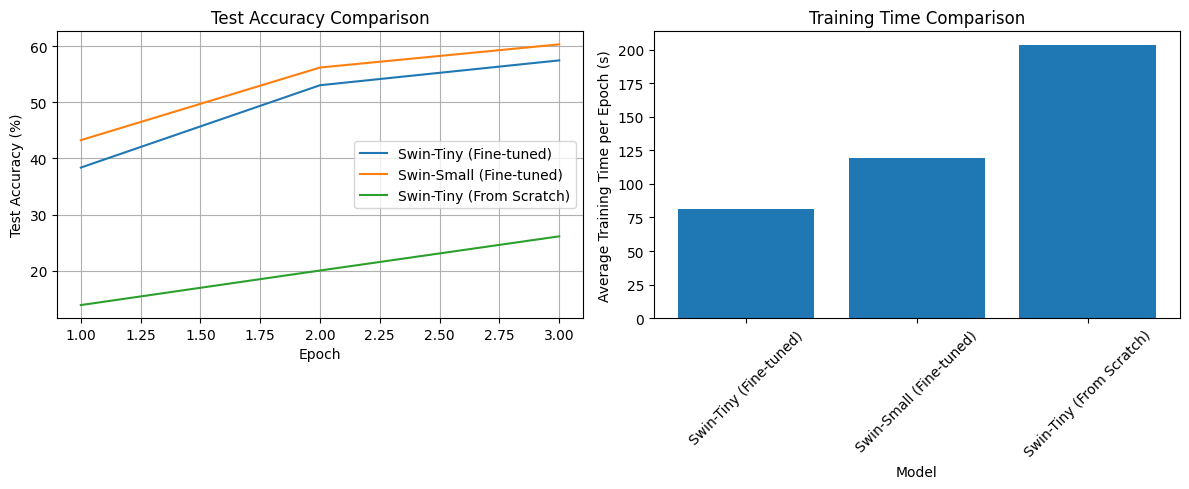

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from transformers import SwinForImageClassification, SwinConfig
import time
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary
import copy

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs).logits
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    train_loss = running_loss / len(train_loader)
    train_acc = 100.0 * correct / total
    epoch_time = time.time() - start_time
    
    return train_loss, train_acc, epoch_time

def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).logits
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    test_loss = running_loss / len(test_loader)
    test_acc = 100.0 * correct / total
    
    return test_loss, test_acc

def count_params(model):
    """Count trainable parameters."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def run_experiment(model, model_name, train_loader, test_loader, num_epochs=5, finetune=True):
    print(f"Running experiment with {model_name}")
    
    # Calculate parameters
    params = count_params(model)
    print(f"Number of trainable parameters: {params:,}")
    
    # Set up training
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=2e-5)
    
    # Training loop
    model.to(device)
    results = {
        "model_name": model_name,
        "params": params,
        "train_time_per_epoch": [],
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    for epoch in range(num_epochs):
        # Train
        train_loss, train_acc, epoch_time = train(model, train_loader, criterion, optimizer, device)
        
        # Evaluate
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)
        
        # Record results
        results["train_time_per_epoch"].append(epoch_time)
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%, Time: {epoch_time:.2f}s")
    
    # Calculate average metrics
    results["avg_train_time"] = np.mean(results["train_time_per_epoch"])
    results["final_test_acc"] = results["test_acc"][-1]
    
    return results

def freeze_backbone(model):
    """Freeze the backbone layers, keeping only the classifier trainable."""
    for name, param in model.named_parameters():
        if 'classifier' not in name:  # Freeze everything except the classifier
            param.requires_grad = False
    return model

# Define a custom resize transform class instead of using Lambda
class ResizeCIFAR(object):
    def __init__(self, target_size=224):
        self.target_size = target_size
        
    def __call__(self, img):
        # Add batch dimension, resize, then remove batch dimension
        img = img.unsqueeze(0)
        img = torch.nn.functional.interpolate(
            img, size=(self.target_size, self.target_size), 
            mode='bilinear', align_corners=False
        )
        return img.squeeze(0)

def main():
    # Data preprocessing with resize for Swin Transformer (needs 224x224)
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
        ResizeCIFAR(target_size=224)
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
        ResizeCIFAR(target_size=224)
    ])
    
    # Load CIFAR-100 dataset
    trainset = torchvision.datasets.CIFAR100(
        root='./data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=32, shuffle=True, num_workers=0)  # Set num_workers to 0 to avoid multiprocessing issues
    
    testset = torchvision.datasets.CIFAR100(
        root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=32, shuffle=False, num_workers=0)  # Set num_workers to 0 to avoid multiprocessing issues
    
    # Create a dictionary to store all results
    all_results = []
    num_epochs = 3  # Set to 3 epochs for demonstration (within 2-5 range)
    
    # 1. Fine-tune Swin-Tiny model
    print("Loading Swin-Tiny pretrained model...")
    swin_tiny = SwinForImageClassification.from_pretrained("microsoft/swin-tiny-patch4-window7-224", 
                                                          num_labels=100, 
                                                          ignore_mismatched_sizes=True)
    # Freeze backbone
    swin_tiny = freeze_backbone(swin_tiny)
    
    swin_tiny_results = run_experiment(
        model=swin_tiny,
        model_name="Swin-Tiny (Fine-tuned)",
        train_loader=trainloader,
        test_loader=testloader,
        num_epochs=num_epochs
    )
    all_results.append(swin_tiny_results)
    
    # 2. Fine-tune Swin-Small model
    print("Loading Swin-Small pretrained model...")
    swin_small = SwinForImageClassification.from_pretrained("microsoft/swin-small-patch4-window7-224", 
                                                           num_labels=100, 
                                                           ignore_mismatched_sizes=True)
    # Freeze backbone
    swin_small = freeze_backbone(swin_small)
    
    swin_small_results = run_experiment(
        model=swin_small,
        model_name="Swin-Small (Fine-tuned)",
        train_loader=trainloader,
        test_loader=testloader,
        num_epochs=num_epochs
    )
    all_results.append(swin_small_results)
    
    # 3. Train Swin-Tiny from scratch
    print("Creating Swin-Tiny model from scratch...")
    # Create Swin-Tiny configuration
    config = SwinConfig(
        num_labels=100,
        image_size=224,
        patch_size=4,
        num_channels=3,
        embed_dim=96,
        depths=[2, 2, 6, 2],
        num_heads=[3, 6, 12, 24],
        window_size=7
    )
    
    swin_scratch = SwinForImageClassification(config)
    
    swin_scratch_results = run_experiment(
        model=swin_scratch,
        model_name="Swin-Tiny (From Scratch)",
        train_loader=trainloader,
        test_loader=testloader,
        num_epochs=num_epochs
    )
    all_results.append(swin_scratch_results)
    
    # Print results summary table
    print("\nResults Summary:")
    print("-" * 85)
    print(f"{'Model':<25} | {'Trainable Params':<18} | {'Avg Train Time':<15} | {'Final Test Acc':<15}")
    print("-" * 85)
    
    for result in all_results:
        print(f"{result['model_name']:<25} | {result['params']:,} | {result['avg_train_time']:.2f}s | {result['final_test_acc']:.2f}%")
    
    # Visualize accuracy comparison
    plt.figure(figsize=(12, 5))
    
    # Plot test accuracy
    plt.subplot(1, 2, 1)
    for result in all_results:
        plt.plot(range(1, num_epochs+1), result['test_acc'], label=result['model_name'])
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy (%)')
    plt.title('Test Accuracy Comparison')
    plt.legend()
    plt.grid(True)
    
    # Plot training time
    plt.subplot(1, 2, 2)
    model_names = [result['model_name'] for result in all_results]
    avg_times = [result['avg_train_time'] for result in all_results]
    plt.bar(model_names, avg_times)
    plt.xlabel('Model')
    plt.ylabel('Average Training Time per Epoch (s)')
    plt.title('Training Time Comparison')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    plt.savefig('swin_results_comparison.png')
    plt.show()

if __name__ == "__main__":
    main()